<a href="https://colab.research.google.com/github/take104/kaggle-Ventilator-Pressure-Prediction/blob/main/Ventilator_Pressure_Prediction_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 ! pip install -q kaggle

In [ ]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"kamame4","key":"0840fb18fc1801f257ee4a992b153007"}'}

In [ ]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c ventilator-pressure-prediction

train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!ls #!mkdir test

'kaggle (1).json'   sample_submission.csv.zip   train.csv.zip
 kaggle.json	    sub_baseline.csv
 sample_data	    test.csv.zip


In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

import os
import time

import lightgbm as lgb
from sklearn.model_selection import GroupKFold
from sklearn import metrics

train = pd.read_csv("/content/train.csv.zip") #reading the train.csv zip file and store in train variable
test = pd.read_csv("/content/test.csv.zip") #reading the test.csv zip flie and store in test variable
sub = pd.read_csv("/content/sample_submission.csv.zip")

In [ ]:
train

,id,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,1,20,50,0.000000,0.083334,0,5.837492
1,2,1,20,50,0.033652,18.383041,0,5.907794
2,3,1,20,50,0.067514,22.509278,0,7.876254
3,4,1,20,50,0.101542,22.808822,0,11.742872
4,5,1,20,50,0.135756,25.355850,0,12.234987
...,...,...,...,...,...,...,...,...
6035995,6035996,125749,50,10,2.504603,1.489714,1,3.869032
6035996,6035997,125749,50,10,2.537961,1.488497,1,3.869032
6035997,6035998,125749,50,10,2.571408,1.558978,1,3.798729
6035998,6035999,125749,50,10,2.604744,1.272663,1,4.079938


In [ ]:
train[train['breath_id']==1]

,id,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,1,20,50,0.000000,0.083334,0,5.837492
1,2,1,20,50,0.033652,18.383041,0,5.907794
2,3,1,20,50,0.067514,22.509278,0,7.876254
3,4,1,20,50,0.101542,22.808822,0,11.742872
4,5,1,20,50,0.135756,25.355850,0,12.234987
...,...,...,...,...,...,...,...,...
75,76,1,20,50,2.553593,4.974474,1,6.399909
76,77,1,20,50,2.587754,4.978481,1,6.610815
77,78,1,20,50,2.621773,4.981847,1,6.329607
78,79,1,20,50,2.655746,4.984683,1,6.540513


In [ ]:
train[train['time_step']==0].describe()

,id,breath_id,R,C,time_step,u_in,u_out,pressure
count,7.545000e+04,75450.000000,75450.000000,75450.000000,75450.0,75450.000000,75450.0,75450.000000
mean,3.017961e+06,62838.858701,27.036183,26.080716,0.0,13.910675,0.0,5.810529
std,1.742455e+06,36335.493977,19.595619,17.152426,0.0,25.137113,0.0,1.015653
min,1.000000e+00,1.000000,5.000000,10.000000,0.0,0.000000,0.0,-1.825442
25%,1.508981e+06,31377.250000,5.000000,10.000000,0.0,0.000000,0.0,5.485981
50%,3.017961e+06,62765.500000,20.000000,20.000000,0.0,2.027507,0.0,6.189002
75%,4.526941e+06,94300.750000,50.000000,50.000000,0.0,14.088825,0.0,6.399909
max,6.035921e+06,125749.000000,50.000000,50.000000,0.0,100.000000,0.0,7.454441


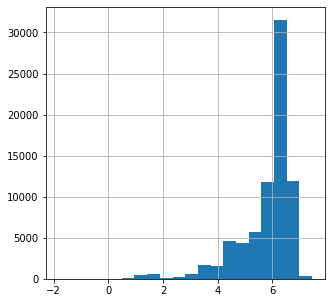

In [ ]:
# 時間０時の圧力値分布
from pylab import rcParams
rcParams['figure.figsize'] = 5,5
train[train['time_step']==0]['pressure'].hist(bins=20)

In [ ]:
train.groupby(['breath_id', 'R', 'C']).count()

,,,id,time_step,u_in,u_out,pressure
breath_id,R,C,,,,,
1,20,50,80,80,80,80,80
2,20,20,80,80,80,80,80
3,50,20,80,80,80,80,80
4,50,50,80,80,80,80,80
5,5,50,80,80,80,80,80
...,...,...,...,...,...,...,...
125740,50,50,80,80,80,80,80
125742,20,10,80,80,80,80,80
125743,20,10,80,80,80,80,80


In [ ]:
train['R'].unique(), train['C'].unique()

(array([20, 50,  5]), array([50, 20, 10]))

In [ ]:
train[(train['R'] == 20) & (train['C'] == 50)].head(30)
#breath_id でgroupbyなってない　✗

,id,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,1,20,50,0.000000,0.083334,0,5.837492
1,2,1,20,50,0.033652,18.383041,0,5.907794
2,3,1,20,50,0.067514,22.509278,0,7.876254
3,4,1,20,50,0.101542,22.808822,0,11.742872
4,5,1,20,50,0.135756,25.355850,0,12.234987
5,6,1,20,50,0.169698,27.259866,0,12.867706
6,7,1,20,50,0.203708,27.127486,0,14.695562
7,8,1,20,50,0.237723,26.807732,0,15.890699
8,9,1,20,50,0.271776,27.864715,0,15.539188
9,10,1,20,50,0.305732,28.313036,0,15.750094


In [ ]:
train['R'].unique(), train['C'].unique()

(array([20, 50,  5]), array([50, 20, 10]))

In [ ]:
# R, Cの組み合わせと対応するidを前から３０個持ってくる
conbi_list = []
for i in train['R'].unique():
    for j in train['C'].unique():
        R = i
        C = j
        #id_head_9 = train[(train['R'] == i) & (train['C'] == j)].head(30)['id'].to_list() #
        ind = train[(train['R'] == i) & (train['C'] == j)].groupby(['breath_id', 'R', 'C']).count().head(30).index
        #余計なR,Cを除外（breath_idのみ抽出）
        list_id = []
        for k in range(ind.size):
            list_id.append(ind[k][0])
        
        #conbi_list.append((R, C, id_head_9))
        conbi_list.append((R, C, list_id))

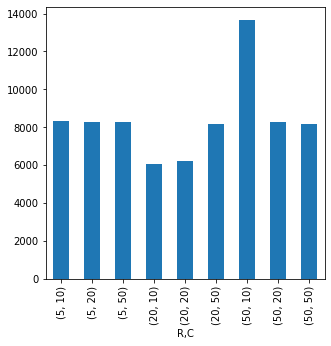

In [ ]:
(train.groupby(['R', 'C'])['id'].count()/80).plot(kind='bar')

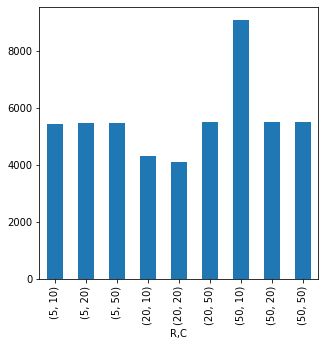

In [ ]:
(test.groupby(['R', 'C'])['id'].count()/80).plot(kind='bar')

In [ ]:
conbi_list[0][0], conbi_list[0][1], conbi_list[0][2][4]

(20, 50, 104)

In [ ]:
#各RとCの組み合わせ別にグラフ化

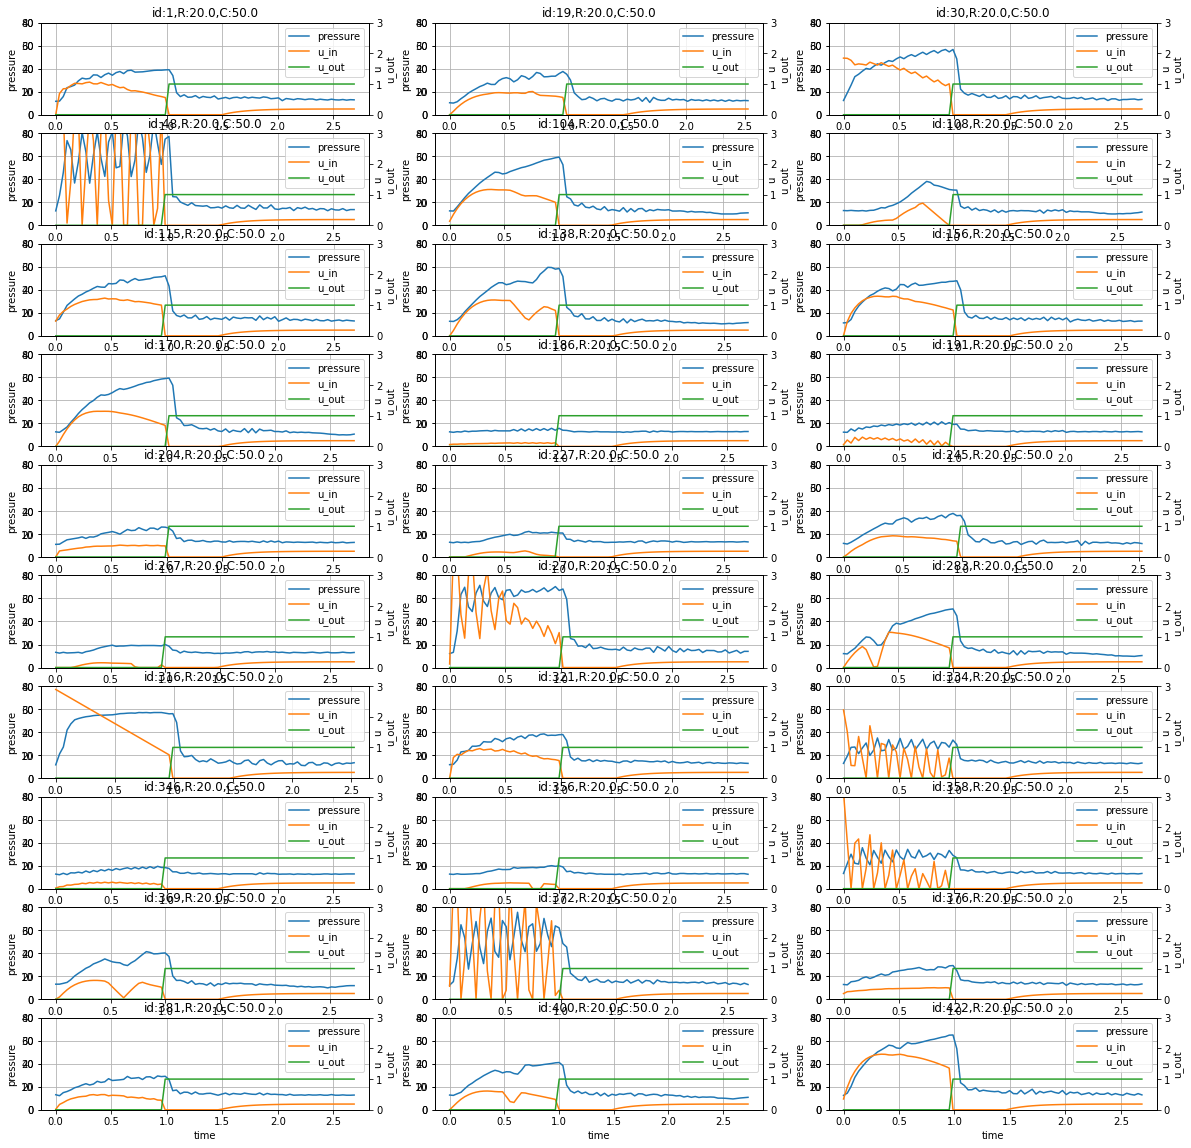

In [ ]:
l = 0
R = conbi_list[l][0]
C = conbi_list[l][1]

fig = plt.figure(figsize=(20,20))

for k in range(30):
    m = conbi_list[l][2][k]
    ax1 = fig.add_subplot(10,3,k+1)
    t = train[train['breath_id']==m]['time_step']
    y1 = train[train['breath_id']==m]['pressure']
    ln1 = ax1.plot(t, y1,'C0',label='pressure')

    ax2 = ax1.twinx()
    y2 = train[train['breath_id']==m]['u_in']
    ln2=ax2.plot(t,y2,'C1',label='u_in')

    ax3 = ax2.twinx()
    y3 = train[train['breath_id']==m]['u_out']
    ln3=ax3.plot(t,y3,'C2',label='u_out')

    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    h3, l3 = ax3.get_legend_handles_labels()
    ax1.legend(h1+h2+h3, l1+l2+l3)

    R = train[train['breath_id']==m]['R'].mean()
    C = train[train['breath_id']==m]['C'].mean()
    title = "id:{},R:{},C:{}".format(m, R, C)
    ax1.set_title(title)
    ax1.set_ylim([0,40])
    ax1.set_xlabel('time')
    ax1.set_ylabel(r'pressure')
    ax1.grid(True)
    ax2.set_ylabel(r'u')
    ax2.set_ylim([0,80])

    ax3.set_ylabel(r'u_out')
    ax3.set_ylim([0,3])

In [ ]:
test['breath_id'].value_counts()

8188      80
4773      80
119453    80
103061    80
105108    80
          ..
118120    80
111975    80
114022    80
107877    80
0         80
Name: breath_id, Length: 50300, dtype: int64

In [ ]:
# Feature Engineering for train

#u_in, u_outの１〜３ステップ前後の値を追加
train['last_value_u_in'] = train.groupby('breath_id')['u_in'].transform('last')

train['u_in_lag1'] = train.groupby('breath_id')['u_in'].shift(1)
train['u_out_lag1'] = train.groupby('breath_id')['u_out'].shift(1)
train['u_in_lag_back1'] = train.groupby('breath_id')['u_in'].shift(-1)
train['u_out_lag_back1'] = train.groupby('breath_id')['u_out'].shift(-1)
train['u_in_lag2'] = train.groupby('breath_id')['u_in'].shift(2)
train['u_out_lag2'] = train.groupby('breath_id')['u_out'].shift(2)
train['u_in_lag_back2'] = train.groupby('breath_id')['u_in'].shift(-2)
train['u_out_lag_back2'] = train.groupby('breath_id')['u_out'].shift(-2)
train['u_in_lag3'] = train.groupby('breath_id')['u_in'].shift(3)
train['u_out_lag3'] = train.groupby('breath_id')['u_out'].shift(3)
train['u_in_lag_back3'] = train.groupby('breath_id')['u_in'].shift(-3)
train['u_out_lag_back3'] = train.groupby('breath_id')['u_out'].shift(-3)
train = train.fillna(0)

train['R__C'] = train["R"].astype(str) + '__' + train["C"].astype(str)

# max value of u_in and u_out for each breath
train['breath_id__u_in__max'] = train.groupby(['breath_id'])['u_in'].transform('max')
train['breath_id__u_out__max'] = train.groupby(['breath_id'])['u_out'].transform('max')

# difference between consequitive values
#u_in , u_outの差分（変化量）
train['u_in_diff1'] = train['u_in'] - train['u_in_lag1']
train['u_out_diff1'] = train['u_out'] - train['u_out_lag1']
train['u_in_diff2'] = train['u_in'] - train['u_in_lag2']
train['u_out_diff2'] = train['u_out'] - train['u_out_lag2']
# from here: https://www.kaggle.com/yasufuminakama/ventilator-pressure-lstm-starter
train.loc[train['time_step'] == 0, 'u_in_diff'] = 0
train.loc[train['time_step'] == 0, 'u_out_diff'] = 0

# difference between the current value of u_in and the max value within the breath
train['breath_id__u_in__diffmax'] = train.groupby(['breath_id'])['u_in'].transform('max') - train['u_in']
train['breath_id__u_in__diffmean'] = train.groupby(['breath_id'])['u_in'].transform('mean') - train['u_in']

# カテゴリ変数であるRとCの組み合わせをOneHotEncoder
train = train.merge(pd.get_dummies(train['R'], prefix='R'), left_index=True, right_index=True).drop(['R'], axis=1)
train = train.merge(pd.get_dummies(train['C'], prefix='C'), left_index=True, right_index=True).drop(['C'], axis=1)
train = train.merge(pd.get_dummies(train['R__C'], prefix='R__C'), left_index=True, right_index=True).drop(['R__C'], axis=1)

# https://www.kaggle.com/c/ventilator-pressure-prediction/discussion/273974
#u_inの累積和
train['u_in_cumsum'] = train.groupby(['breath_id'])['u_in'].cumsum()
train['time_step_cumsum'] = train.groupby(['breath_id'])['time_step'].cumsum()

train

,id,breath_id,time_step,u_in,u_out,pressure,last_value_u_in,u_in_lag1,u_out_lag1,u_in_lag_back1,u_out_lag_back1,u_in_lag2,u_out_lag2,u_in_lag_back2,u_out_lag_back2,u_in_lag3,u_out_lag3,u_in_lag_back3,u_out_lag_back3,breath_id__u_in__max,breath_id__u_out__max,u_in_diff1,u_out_diff1,u_in_diff2,u_out_diff2,u_in_diff,u_out_diff,breath_id__u_in__diffmax,breath_id__u_in__diffmean,R_5,R_20,R_50,C_10,C_20,C_50,R__C_20__10,R__C_20__20,R__C_20__50,R__C_50__10,R__C_50__20,R__C_50__50,R__C_5__10,R__C_5__20,R__C_5__50,u_in_cumsum,time_step_cumsum
0,1,1,0.000000,0.083334,0,5.837492,4.987079,0.000000,0.0,18.383041,0.0,0.000000,0.0,22.509278,0.0,0.000000,0.0,22.808822,0.0,28.313036,1,0.083334,0.0,0.083334,0.0,0.0,0.0,28.229702,10.062673,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0.083334,0.000000
1,2,1,0.033652,18.383041,0,5.907794,4.987079,0.083334,0.0,22.509278,0.0,0.000000,0.0,22.808822,0.0,0.000000,0.0,25.355850,0.0,28.313036,1,18.299707,0.0,18.383041,0.0,NaN,NaN,9.929994,-8.237035,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,18.466375,0.033652
2,3,1,0.067514,22.509278,0,7.876254,4.987079,18.383041,0.0,22.808822,0.0,0.083334,0.0,25.355850,0.0,0.000000,0.0,27.259866,0.0,28.313036,1,4.126236,0.0,22.425944,0.0,NaN,NaN,5.803758,-12.363271,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,40.975653,0.101167
3,4,1,0.101542,22.808822,0,11.742872,4.987079,22.509278,0.0,25.355850,0.0,18.383041,0.0,27.259866,0.0,0.083334,0.0,27.127486,0.0,28.313036,1,0.299544,0.0,4.425781,0.0,NaN,NaN,5.504214,-12.662816,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,63.784476,0.202709
4,5,1,0.135756,25.355850,0,12.234987,4.987079,22.808822,0.0,27.259866,0.0,22.509278,0.0,27.127486,0.0,18.383041,0.0,26.807732,0.0,28.313036,1,2.547028,0.0,2.846573,0.0,NaN,NaN,2.957185,-15.209844,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,89.140326,0.338464
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6035995,6035996,125749,2.504603,1.489714,1,3.869032,1.482739,1.420711,1.0,1.488497,1.0,1.353205,1.0,1.558978,1.0,1.357586,1.0,1.272663,1.0,25.504196,1,0.069002,0.0,0.136509,0.0,NaN,NaN,24.014482,3.421689,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,387.109297,95.147046
6035996,6035997,125749,2.537961,1.488497,1,3.869032,1.482739,1.489714,1.0,1.558978,1.0,1.420711,1.0,1.272663,1.0,1.353205,1.0,1.482739,1.0,25.504196,1,-0.001217,0.0,0.067785,0.0,NaN,NaN,24.015699,3.422905,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,388.597794,97.685006
6035997,6035998,125749,2.571408,1.558978,1,3.798729,1.482739,1.488497,1.0,1.272663,1.0,1.489714,1.0,1.482739,1.0,1.420711,1.0,0.000000,0.0,25.504196,1,0.070481,0.0,0.069264,0.0,NaN,NaN,23.945218,3.352424,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,390.156772,100.256414
6035998,6035999,125749,2.604744,1.272663,1,4.079938,1.482739,1.558978,1.0,1.482739,1.0,1.488497,1.0,0.000000,0.0,1.489714,1.0,0.000000,0.0,25.504196,1,-0.286315,0.0,-0.215834,0.0,NaN,NaN,24.231532,3.638739,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,391.429435,102.861158


In [ ]:
# Feature Engineering for test
test['last_value_u_in'] = test.groupby('breath_id')['u_in'].transform('last')
test['u_in_lag1'] = test.groupby('breath_id')['u_in'].shift(1)
test['u_out_lag1'] = test.groupby('breath_id')['u_out'].shift(1)
test['u_in_lag_back1'] = test.groupby('breath_id')['u_in'].shift(-1)
test['u_out_lag_back1'] = test.groupby('breath_id')['u_out'].shift(-1)
test['u_in_lag2'] = test.groupby('breath_id')['u_in'].shift(2)
test['u_out_lag2'] = test.groupby('breath_id')['u_out'].shift(2)
test['u_in_lag_back2'] = test.groupby('breath_id')['u_in'].shift(-2)
test['u_out_lag_back2'] = test.groupby('breath_id')['u_out'].shift(-2)
test['u_in_lag3'] = test.groupby('breath_id')['u_in'].shift(3)
test['u_out_lag3'] = test.groupby('breath_id')['u_out'].shift(3)
test['u_in_lag_back3'] = test.groupby('breath_id')['u_in'].shift(-3)
test['u_out_lag_back3'] = test.groupby('breath_id')['u_out'].shift(-3)
test = test.fillna(0)
test['R__C'] = test["R"].astype(str) + '__' + test["C"].astype(str)

test['breath_id__u_in__max'] = test.groupby(['breath_id'])['u_in'].transform('max')
test['breath_id__u_out__max'] = test.groupby(['breath_id'])['u_out'].transform('max')

test['u_in_diff1'] = test['u_in'] - test['u_in_lag1']
test['u_out_diff1'] = test['u_out'] - test['u_out_lag1']
test['u_in_diff2'] = test['u_in'] - test['u_in_lag2']
test['u_out_diff2'] = test['u_out'] - test['u_out_lag2']
test.loc[test['time_step'] == 0, 'u_in_diff'] = 0
test.loc[test['time_step'] == 0, 'u_out_diff'] = 0

test['breath_id__u_in__diffmax'] = test.groupby(['breath_id'])['u_in'].transform('max') - test['u_in']
test['breath_id__u_in__diffmean'] = test.groupby(['breath_id'])['u_in'].transform('mean') - test['u_in']

test = test.merge(pd.get_dummies(test['R'], prefix='R'), left_index=True, right_index=True).drop(['R'], axis=1)
test = test.merge(pd.get_dummies(test['C'], prefix='C'), left_index=True, right_index=True).drop(['C'], axis=1)
test = test.merge(pd.get_dummies(test['R__C'], prefix='R__C'), left_index=True, right_index=True).drop(['R__C'], axis=1)

test['u_in_cumsum'] = test.groupby(['breath_id'])['u_in'].cumsum()
test['time_step_cumsum'] = test.groupby(['breath_id'])['time_step'].cumsum()

In [ ]:
#Model Training
scores = []
feature_importance = pd.DataFrame()
models = []
columns = [col for col in train.columns if col not in ['id', 'breath_id', 'pressure']]
X = train[columns]
y = train['pressure']

In [ ]:
params = {
    'objective': 'regression',
    'learning_rate': 0.3,
    "boosting_type": "gbdt",
    "metric": 'mae',
    'n_jobs': -1,
    'min_data_in_leaf':32,
    'num_leaves':1024,
    }

In [ ]:
folds = GroupKFold(n_splits=5)
for fold_n, (train_index, valid_index) in enumerate(folds.split(train, y, groups=train['breath_id'])):
    print(f'Fold {fold_n} started at {time.ctime()}')
    X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    model = lgb.LGBMRegressor(**params, n_estimators=10000)
    model.fit(X_train, y_train, 
            eval_set=[(X_train, y_train), (X_valid, y_valid)],
            verbose=1000, early_stopping_rounds=15)
    score = metrics.mean_absolute_error(y_valid, model.predict(X_valid))
    
    models.append(model)
    scores.append(score)

    fold_importance = pd.DataFrame()
    fold_importance["feature"] = columns
    fold_importance["importance"] = model.feature_importances_
    fold_importance["fold"] = fold_n + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

Fold 0 started at Mon Oct  4 01:04:14 2021
Training until validation scores don't improve for 15 rounds.
[1000]	training's l1: 0.196174	valid_1's l1: 0.36479
Early stopping, best iteration is:
[1173]	training's l1: 0.184994	valid_1's l1: 0.363785
Fold 1 started at Mon Oct  4 01:19:19 2021
Training until validation scores don't improve for 15 rounds.
[1000]	training's l1: 0.195352	valid_1's l1: 0.36544
Early stopping, best iteration is:
[1220]	training's l1: 0.181811	valid_1's l1: 0.363981
Fold 2 started at Mon Oct  4 01:34:38 2021
Training until validation scores don't improve for 15 rounds.
[1000]	training's l1: 0.19545	valid_1's l1: 0.366474
Early stopping, best iteration is:
[1585]	training's l1: 0.163916	valid_1's l1: 0.363971
Fold 3 started at Mon Oct  4 01:54:10 2021
Training until validation scores don't improve for 15 rounds.
[1000]	training's l1: 0.195007	valid_1's l1: 0.363141
Early stopping, best iteration is:
[1231]	training's l1: 0.181275	valid_1's l1: 0.361819
Fold 4 star

In [ ]:
print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))

CV mean score: 0.3637, std: 0.0011.


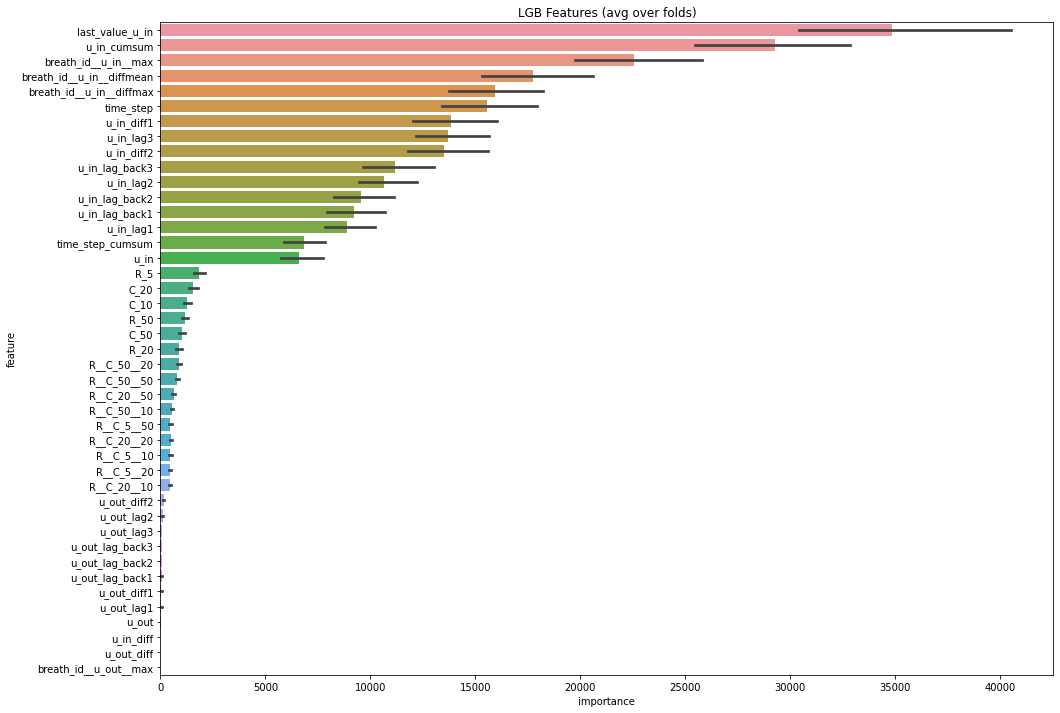

In [ ]:
feature_importance["importance"] /= 5
cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
    by="importance", ascending=False)[:50].index

best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

plt.figure(figsize=(16, 12));
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
plt.title('LGB Features (avg over folds)');

In [ ]:
for model in models:
    sub['pressure'] += model.predict(test[columns])
sub['pressure'] /= 5

In [ ]:
sub.to_csv('sub_baseline.csv', index=False)

In [ ]:
!kaggle competitions submit -c ventilator-pressure-prediction -f sub_baseline.csv -m "Baseline_xgboost_20211003"

100% 99.5M/99.5M [00:03<00:00, 34.0MB/s]
Successfully submitted to Google Brain - Ventilator Pressure Prediction